# LIBRARY INSTALLS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

In [ ]:
df = pd.read_csv('/content/kickstarter_projects.csv')

# DERIVED FEATURES

In [ ]:
df['Launched'] = pd.to_datetime(df['Launched'])
df['Deadline'] = pd.to_datetime(df['Deadline'])

df['Duration'] = (df['Deadline'] - df['Launched']).dt.days

In [ ]:
df.dtypes

,0
ID,int64
Name,object
Category,object
Subcategory,object
Country,object
Launched,datetime64[ns]
Deadline,datetime64[ns]
Goal,int64
Pledged,int64
Backers,int64


In [ ]:
df['LaunchMonth'] = df['Launched'].dt.month

In [ ]:
df['Pledged_to_Goal'] = df['Pledged'] / df['Goal']
df['Pledged_to_Goal'] = df['Pledged_to_Goal'].replace([np.inf, -np.inf], np.nan)


df = df.dropna(subset=['Pledged_to_Goal'])
df['Pledged_to_Goal_logratio'] = np.log10(df['Pledged_to_Goal'] + 1)

<ipython-input-184-dfccbe21974a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pledged_to_Goal_logratio'] = np.log10(df['Pledged_to_Goal'] + 1)


In [ ]:
df['Z_score'] = zscore(df['Pledged_to_Goal_logratio'])

# DATA PREP

In [ ]:
# Filter campaigns with Z-score < -2 (significantly underfunded) or > 3 (overfunded)
under_outliers = df[df['Z_score'] < -2].sort_values(by='Pledged_to_Goal_logratio')
over_outliers = df[df['Z_score'] > 3].sort_values(by='Pledged_to_Goal_logratio', ascending=False)

# EDA

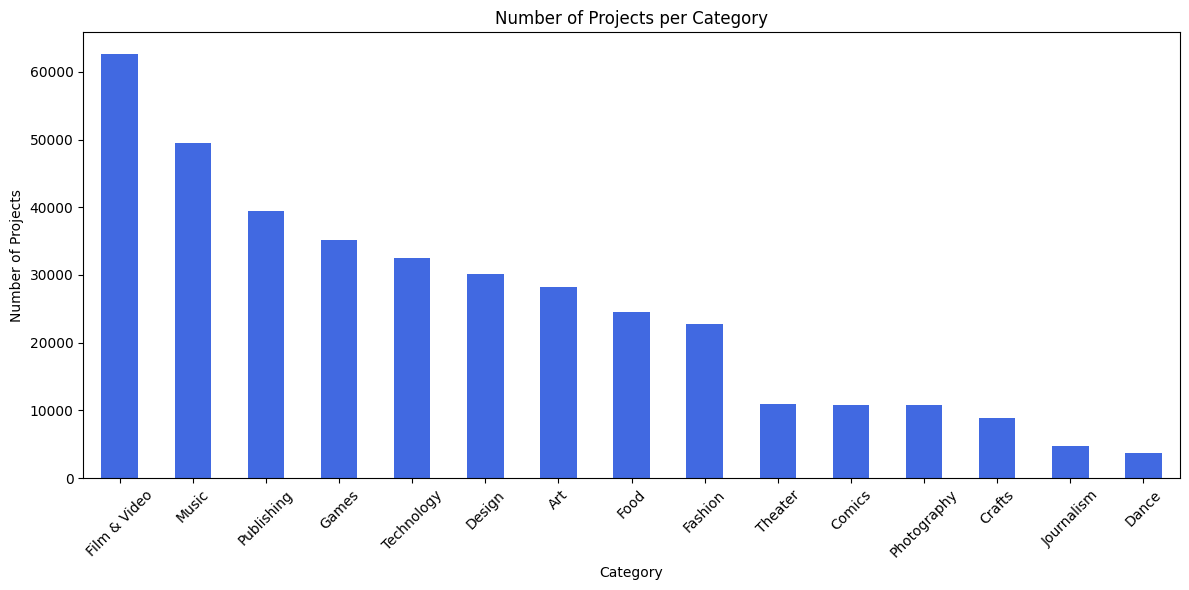

In [ ]:
category_counts = df['Category'].value_counts()

#df.groupby('Category')['State'].value_counts()

category_counts

plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar',color='royalblue')
plt.title('Number of Projects per Category')
plt.xlabel('Category')
plt.ylabel('Number of Projects')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

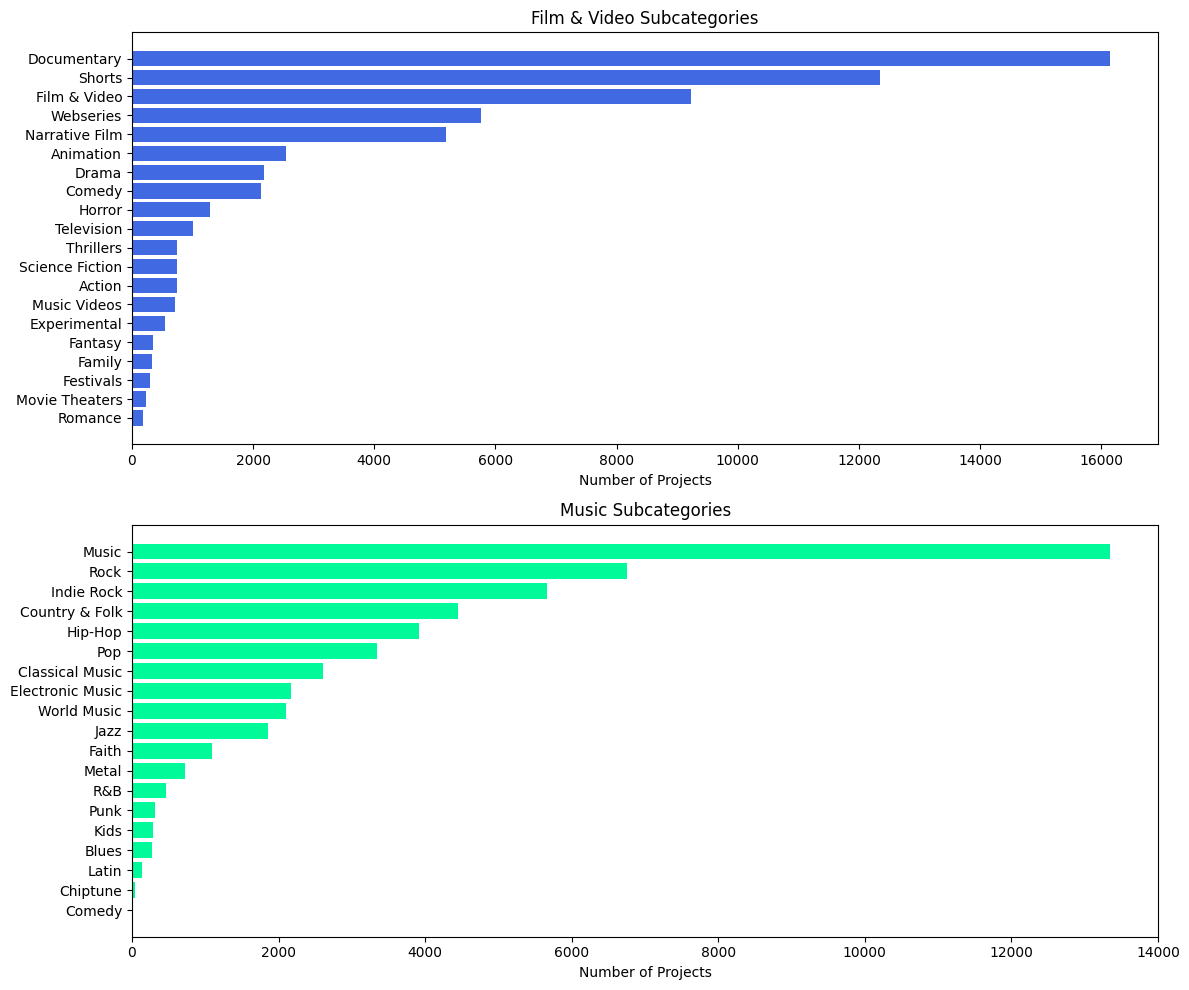

In [ ]:

# Filter only Film & Video and Music categories
filtered_df = df[df['Category'].isin(['Film & Video', 'Music'])]

# Subcategory counts for each category
film_counts = filtered_df[filtered_df['Category'] == 'Film & Video']['Subcategory'].value_counts()
music_counts = filtered_df[filtered_df['Category'] == 'Music']['Subcategory'].value_counts()

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=False,)

# 🎬 Film & Video Plot
axes[0].barh(film_counts.index, film_counts.values, color='royalblue')
axes[0].set_title('Film & Video Subcategories')
axes[0].set_xlabel('Number of Projects')
axes[0].invert_yaxis()  # Highest on top
#for i, v in enumerate(film_counts.values):
#    axes[0].text(v + 50, i, str(v), va='center', fontsize=9)

# 🎵 Music Plot
axes[1].barh(music_counts.index, music_counts.values, color='mediumspringgreen')
axes[1].set_title('Music Subcategories')
axes[1].set_xlabel('Number of Projects')
axes[1].invert_yaxis()
#for i, v in enumerate(music_counts.values):
#    axes[1].text(v + 50, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.show()

<ipython-input-189-0baa38500b3d>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate = df_successrate[df_successrate['State'] == 'Successful'].groupby('Goal Range').size() / df_successrate.groupby('Goal Range').size() * 100
<ipython-input-189-0baa38500b3d>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate = df_successrate[df_successrate['State'] == 'Successful'].groupby('Goal Range').size() / df_successrate.groupby('Goal Range').size() * 100


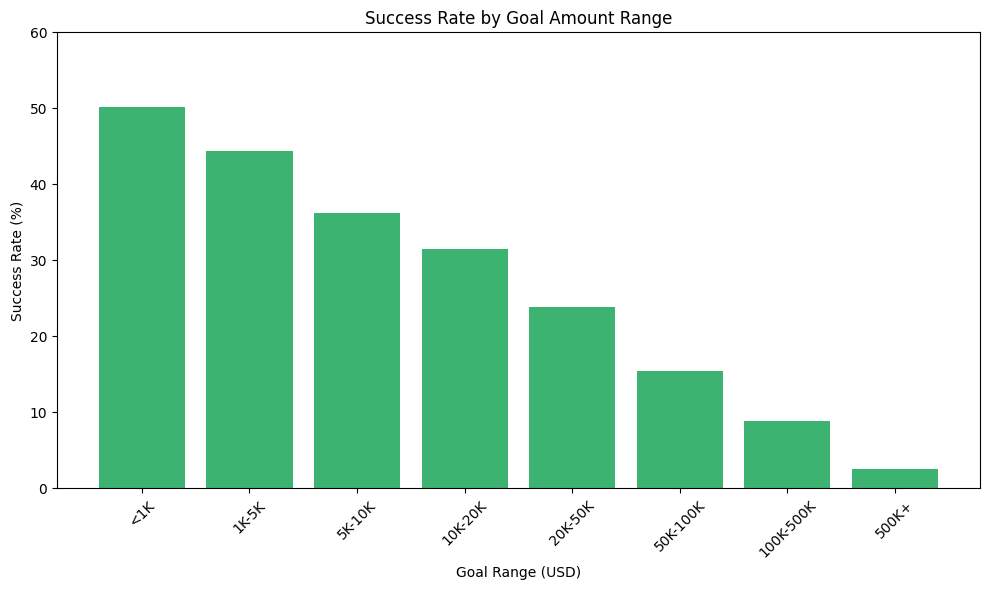

In [ ]:
df_successrate = df[['Goal', 'State']].dropna()
df_successrate = df[df['Goal'] > 0]

# Define goal ranges
bins = [0, 1000, 5000, 10000, 20000, 50000, 100000, 500000, float('inf')]
labels = ['<1K', '1K-5K', '5K-10K', '10K-20K', '20K-50K', '50K-100K', '100K-500K', '500K+']
df_successrate['Goal Range'] = pd.cut(df['Goal'], bins=bins, labels=labels, right=False)

# Calculate success rate per goal range
success_rate = df_successrate[df_successrate['State'] == 'Successful'].groupby('Goal Range').size() / df_successrate.groupby('Goal Range').size() * 100
success_rate = success_rate.sort_index()

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(success_rate.index, success_rate.values, color='mediumseagreen')
plt.title('Success Rate by Goal Amount Range')
plt.xlabel('Goal Range (USD)')
plt.ylabel('Success Rate (%)')
plt.xticks(rotation=45)
plt.ylim(0, 60)
plt.tight_layout()
plt.show()

<ipython-input-190-ac9bfffeb653>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=success_rate.index, y=success_rate.values, palette="viridis")


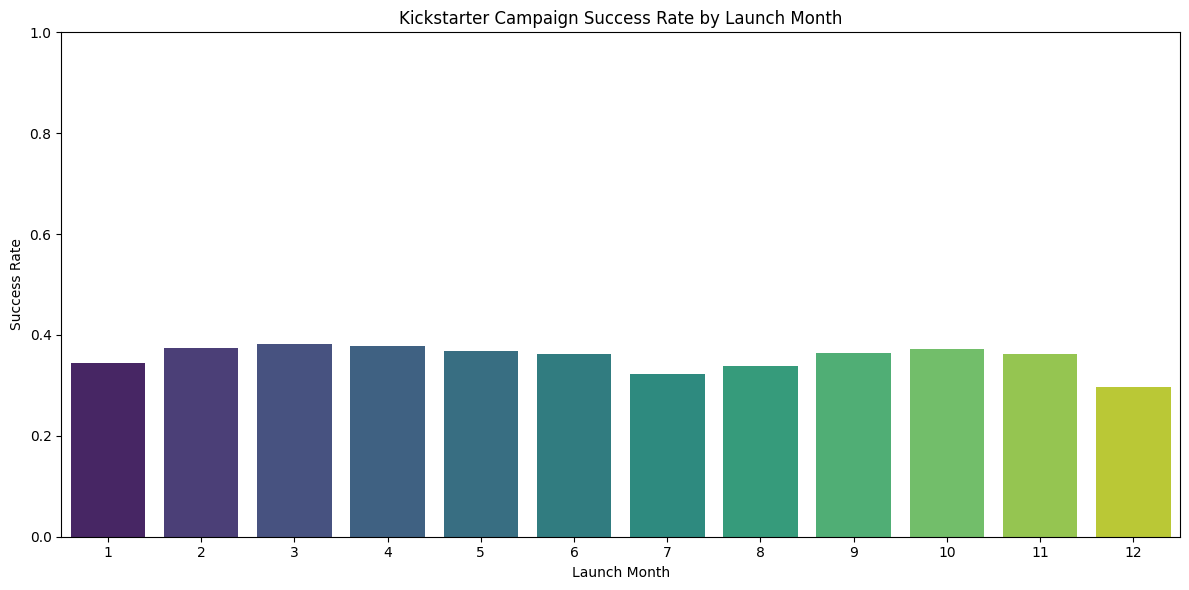

In [ ]:

# Drop rows with missing month
df = df.dropna(subset=['LaunchMonth', 'State'])

# Group by month and calculate success rate
success_rate = df[df['State'] == 'Successful'].groupby('LaunchMonth').size() / df.groupby('LaunchMonth').size()
success_rate = success_rate.sort_index()
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=success_rate.index, y=success_rate.values, palette="viridis")
plt.title("Kickstarter Campaign Success Rate by Launch Month")
plt.xlabel("Launch Month")
plt.ylabel("Success Rate")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

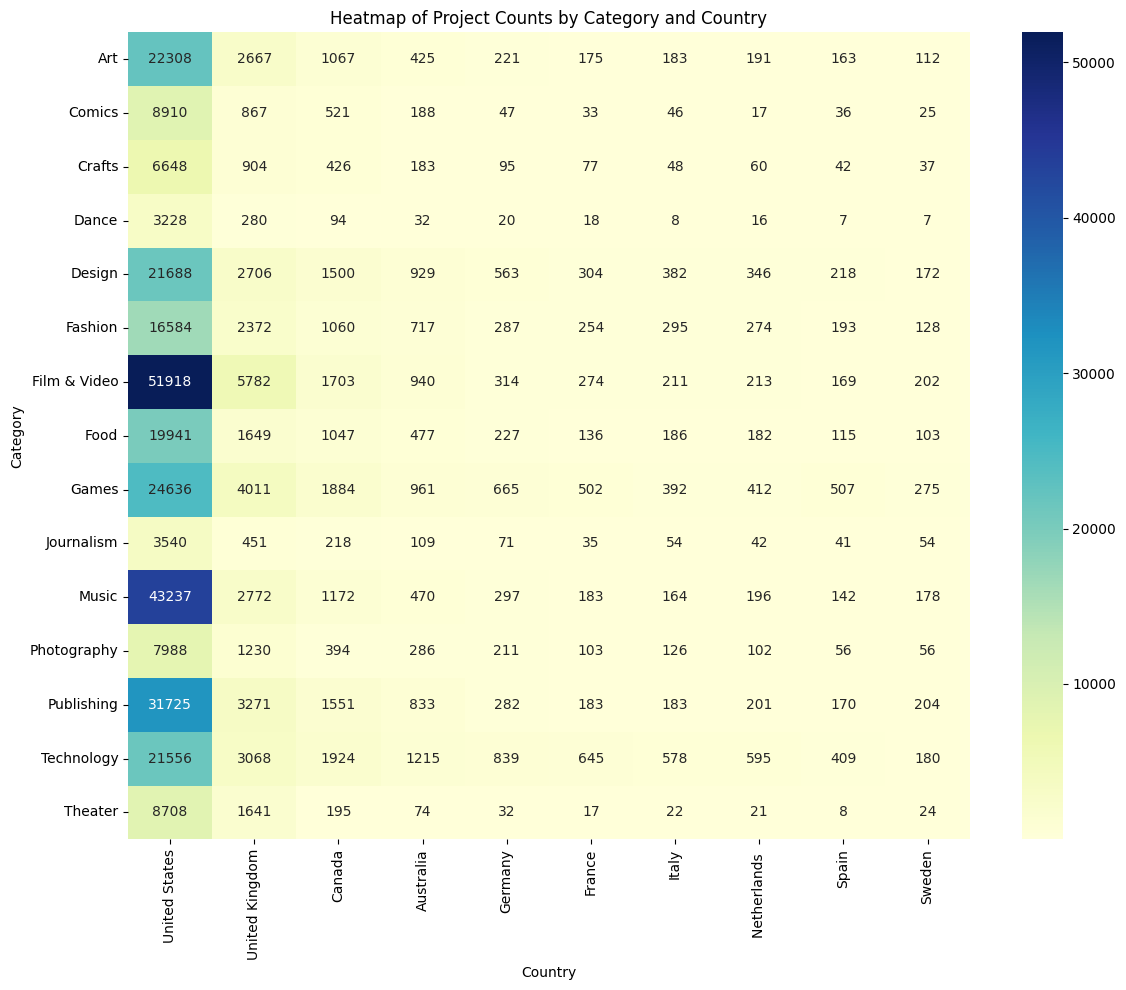

In [ ]:

# Group and filter top countries
grouped = df.groupby(['Category', 'Country']).size().unstack(fill_value=0)

# Optional: limit to top 10 countries
top_countries = df['Country'].value_counts().head(10).index
grouped = grouped[top_countries]

# Plot heatmap (countries on x-axis, categories on y-axis)
plt.figure(figsize=(12, 10))
sns.heatmap(grouped, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Heatmap of Project Counts by Category and Country')
plt.xlabel('Country')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


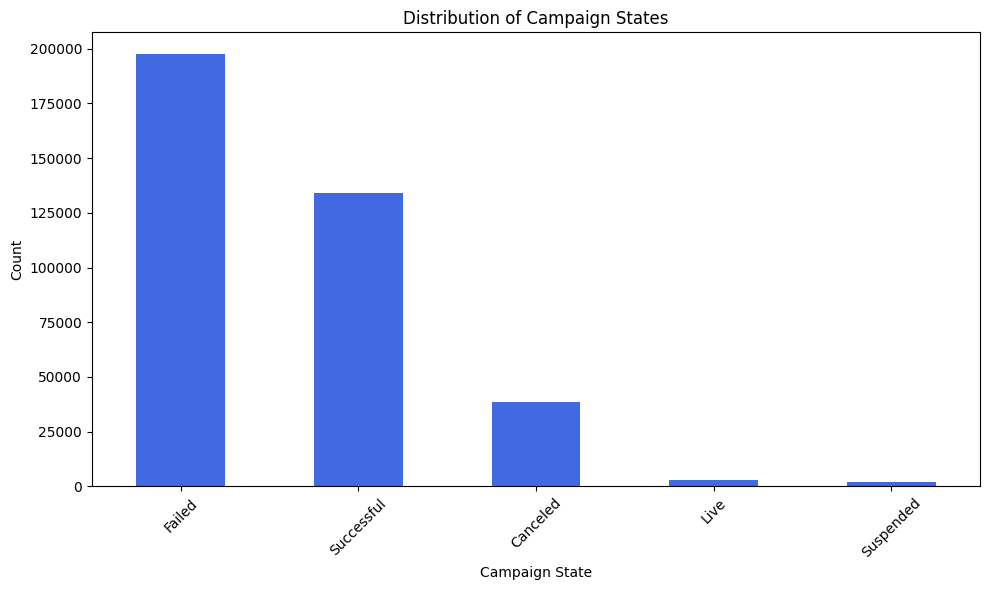

In [ ]:
plt.figure(figsize=(10, 6))
df['State'].value_counts().plot(kind='bar', color='royalblue')
plt.title("Distribution of Campaign States")
plt.xlabel("Campaign State")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

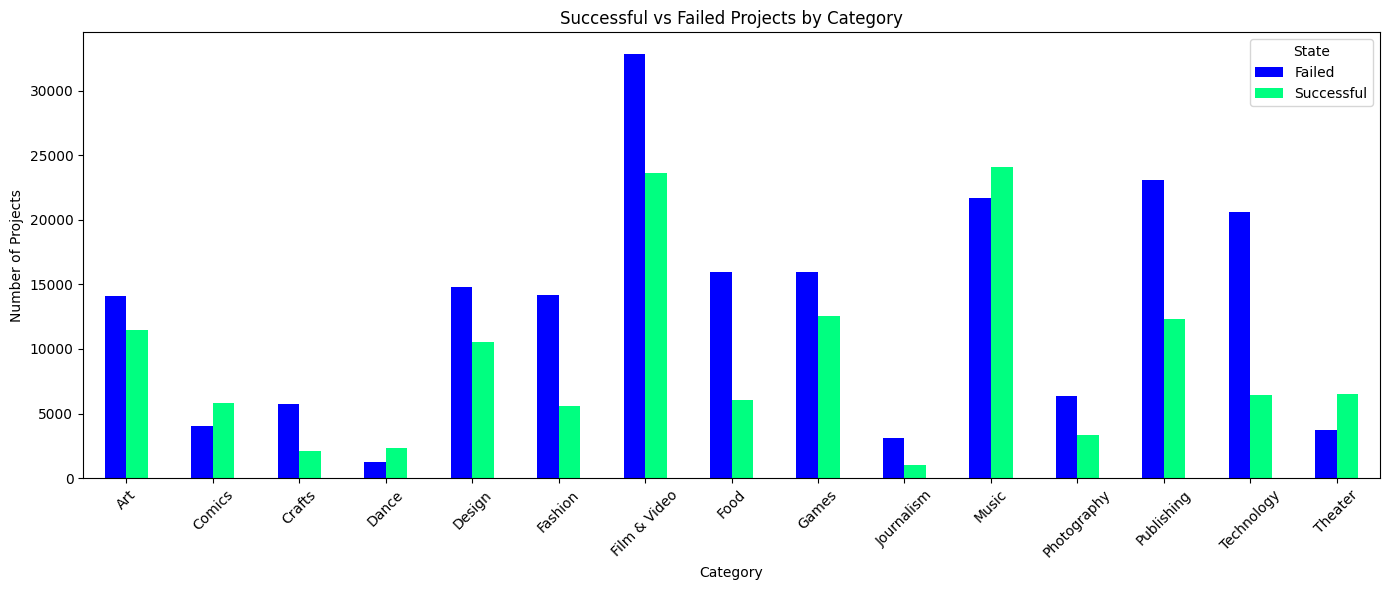

In [ ]:
State_filtered = df[(df['State'] == 'Successful') | (df['State'] == 'Failed')]


grouped_filtered = State_filtered.groupby(['Category', 'State']).size().unstack(fill_value=0)

grouped_filtered.plot(kind='bar', cmap ='winter' ,figsize=(14, 6))
plt.title('Successful vs Failed Projects by Category')
plt.xlabel('Category')
plt.ylabel('Number of Projects')
plt.xticks(rotation=45)
plt.legend(title='State')
plt.tight_layout()
plt.show()

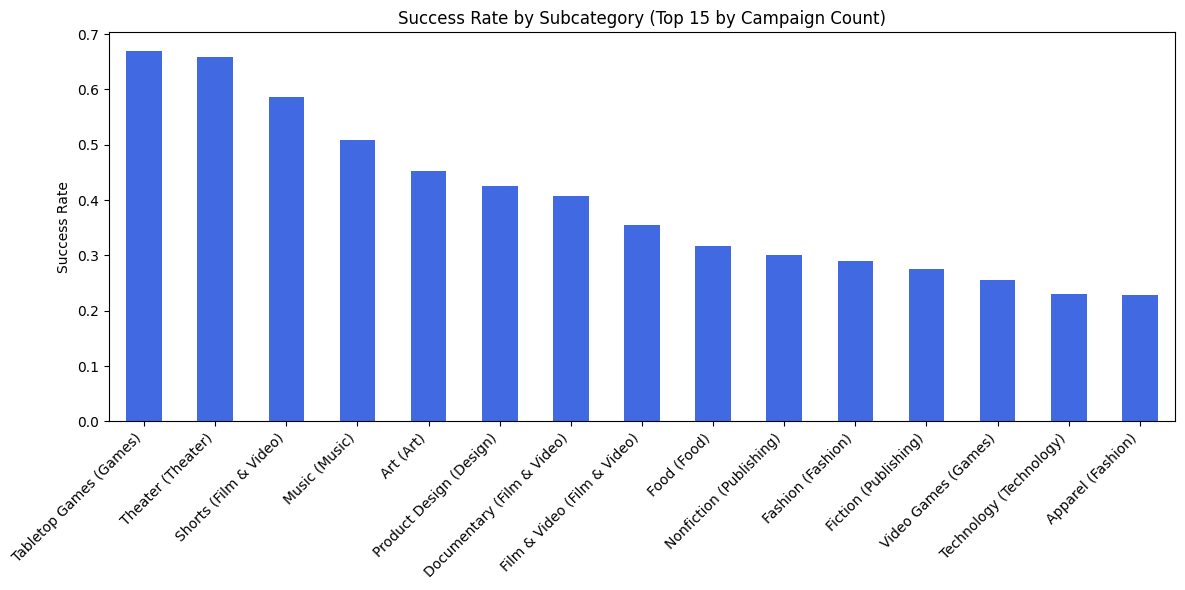

In [ ]:

# Top 15 subcategories
top_subcats = df["Subcategory"].value_counts().nlargest(15).index

# Filter dataset
df_top_subcats = df[df["Subcategory"].isin(top_subcats) & df["State"].isin(["Failed", "Successful"])]

# Create success rate table
subcategory_success_rate = df_top_subcats.groupby("Subcategory")["State"].value_counts(normalize=True).unstack().fillna(0)
subcategory_success_rate = subcategory_success_rate.sort_values("Successful", ascending=False)

# Map subcategory to category
subcat_to_cat = df_top_subcats.drop_duplicates(subset="Subcategory").set_index("Subcategory")["Category"].to_dict()

# Rename index with category info
subcategory_success_rate.index = [f"{subcat} ({subcat_to_cat[subcat]})" for subcat in subcategory_success_rate.index]

# Plot
plt.figure(figsize=(12, 6))
subcategory_success_rate["Successful"].plot(kind="bar", color="royalblue")
plt.title("Success Rate by Subcategory (Top 15 by Campaign Count)")
plt.ylabel("Success Rate")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

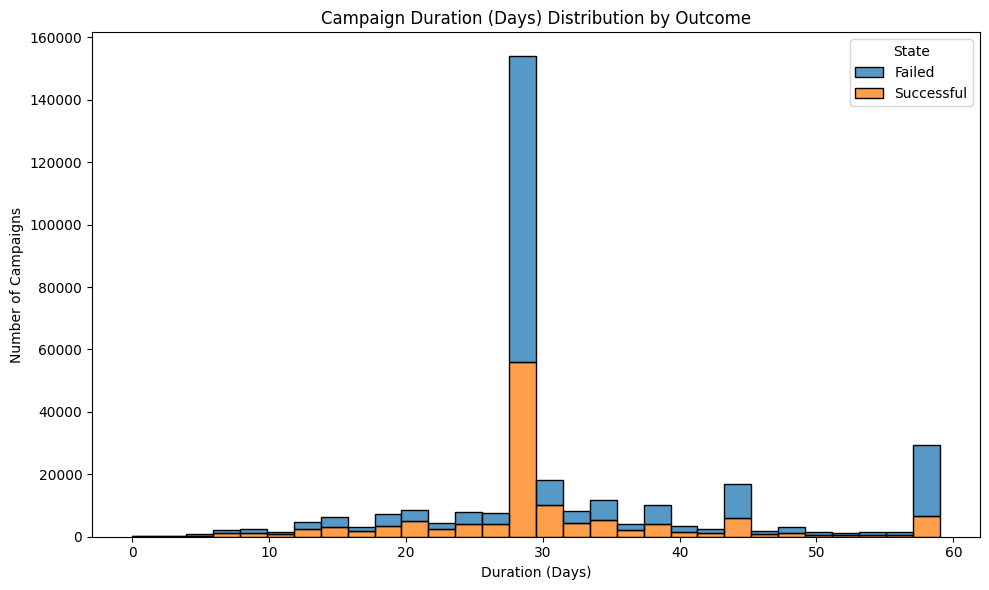

In [ ]:
# Plot: Histogram of Campaign Duration by State (filtered < 60 days for visibility)
df_state = df[df["State"].isin(["Failed", "Successful"])]

plt.figure(figsize=(10, 6))
sns.histplot(data=df_state[df_state["Duration"] < 60], x="Duration", hue="State", bins=30, multiple="stack")
plt.title("Campaign Duration (Days) Distribution by Outcome")
plt.xlabel("Duration (Days)")
plt.ylabel("Number of Campaigns")
plt.tight_layout()
plt.show()

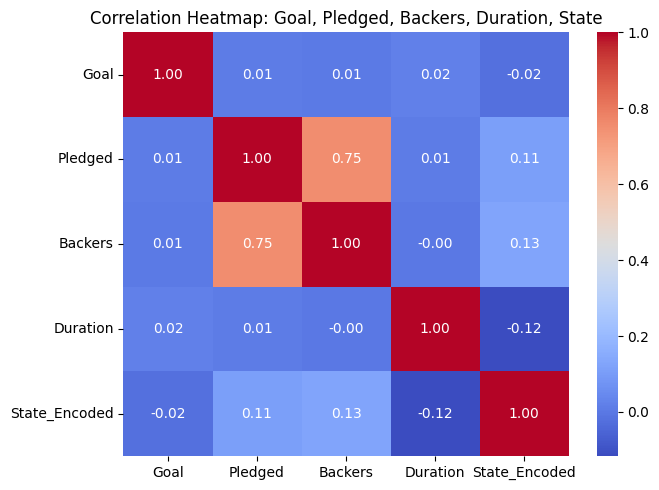

In [ ]:

# Filter to Successful and Failed only
df_filtered = df[df['State'].isin(['Successful', 'Failed'])].copy()

# Convert dates to datetime
df_filtered['Launched'] = pd.to_datetime(df_filtered['Launched'], errors='coerce')
df_filtered['Deadline'] = pd.to_datetime(df_filtered['Deadline'], errors='coerce')

# Calculate campaign duration in days
df_filtered['Duration'] = (df_filtered['Deadline'] - df_filtered['Launched']).dt.days

# Encode State: Successful = 1, Failed = 0
df_filtered['State_Encoded'] = df_filtered['State'].map({'Failed': 0, 'Successful': 1})

# Select and drop rows with any missing values
cols = ['Goal', 'Pledged', 'Backers', 'Duration', 'State_Encoded']
df_selected = df_filtered[cols].dropna()

# Standardize features (except encoded state)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_selected[['Goal', 'Pledged', 'Backers', 'Duration']])

# Create DataFrame and add State_Encoded
df_scaled = pd.DataFrame(scaled_data, columns=['Goal', 'Pledged', 'Backers', 'Duration'])
df_scaled['State_Encoded'] = df_selected['State_Encoded'].values

# Correlation matrix
corr_matrix = df_scaled.corr()

# Plot heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: Goal, Pledged, Backers, Duration, State')
plt.tight_layout()
plt.show()

<ipython-input-197-3af756af8c80>:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


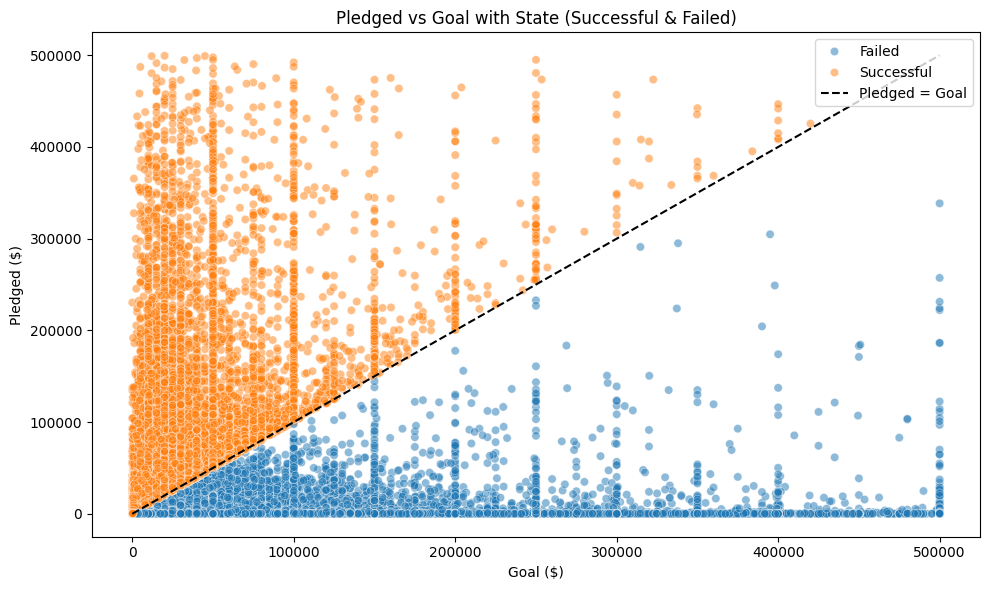

In [ ]:
# Limit extreme values to make the plot readable
df_limited = df_filtered[(df_state['Goal'] <= 500000) & (df_state['Pledged'] <= 500000)]

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_limited,
    x='Goal',
    y='Pledged',
    hue='State',
    alpha=0.5
)

# Add identity line (Pledged = Goal)
plt.plot([0, 500000], [0, 500000], 'k--', label='Pledged = Goal')

# Labels and formatting
plt.title('Pledged vs Goal with State (Successful & Failed)')
plt.xlabel('Goal ($)')
plt.ylabel('Pledged ($)')
plt.legend()
plt.tight_layout()
plt.show()

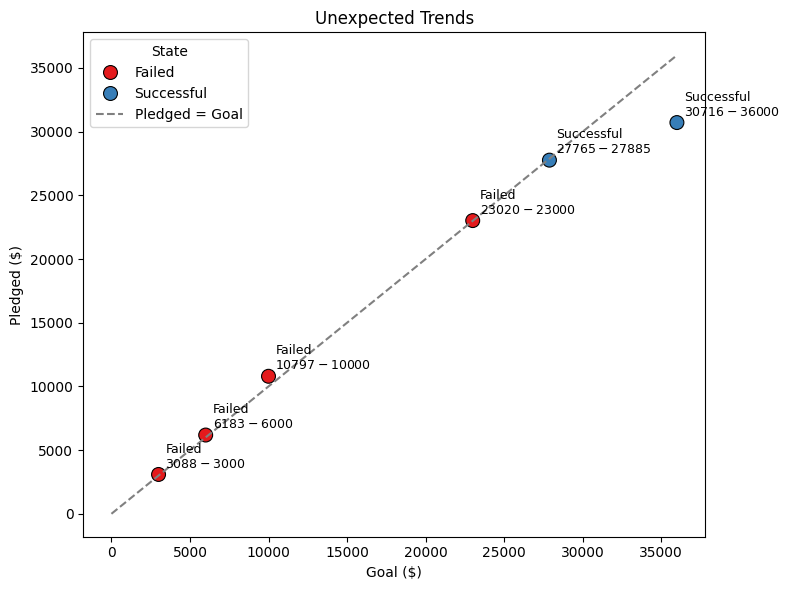

In [ ]:
# Define the outlier conditions
outliers = df_filtered[
    ((df_state['Pledged'] > df_state['Goal']) & (df_state['State'] == 'Failed')) |
    ((df_state['Pledged'] < df_state['Goal']) & (df_state['State'] == 'Successful'))
]

# Plot only the outliers
plt.figure(figsize=(8, 6))
sns.scatterplot(data=outliers, x='Goal', y='Pledged', hue='State', s=100, palette='Set1', edgecolor='black')

# Dashed line for Pledged = Goal
plt.plot([0, outliers['Goal'].max()], [0, outliers['Goal'].max()], linestyle='--', color='gray', label='Pledged = Goal')

# Annotate points
for i, row in outliers.iterrows():
    label = f"{row['State']}\n${int(row['Pledged'])} - ${int(row['Goal'])}"
    plt.annotate(label, (row['Goal'], row['Pledged']), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)

plt.title('Unexpected Trends')
plt.xlabel('Goal ($)')
plt.ylabel('Pledged ($)')
plt.legend(title='State')
plt.tight_layout()
plt.show()

In [ ]:
cols = ['Goal', 'Pledged', 'Backers']
summary = df[cols].describe(percentiles=[0.25, 0.5, 0.75]).loc[['min', '25%', '50%', '75%', 'max']]

# Rename the index for clarity
summary.index = ['min', 'Q1 (25%)', 'Median (50%)', 'Q3 (75%)', 'max']

# Display the summary
print(summary)

                     Goal     Pledged   Backers
min                   1.0         0.0       0.0
Q1 (25%)           2000.0        31.0       2.0
Median (50%)       5500.0       625.0      12.0
Q3 (75%)          16000.0      4051.0      57.0
max           166361391.0  20338986.0  219382.0


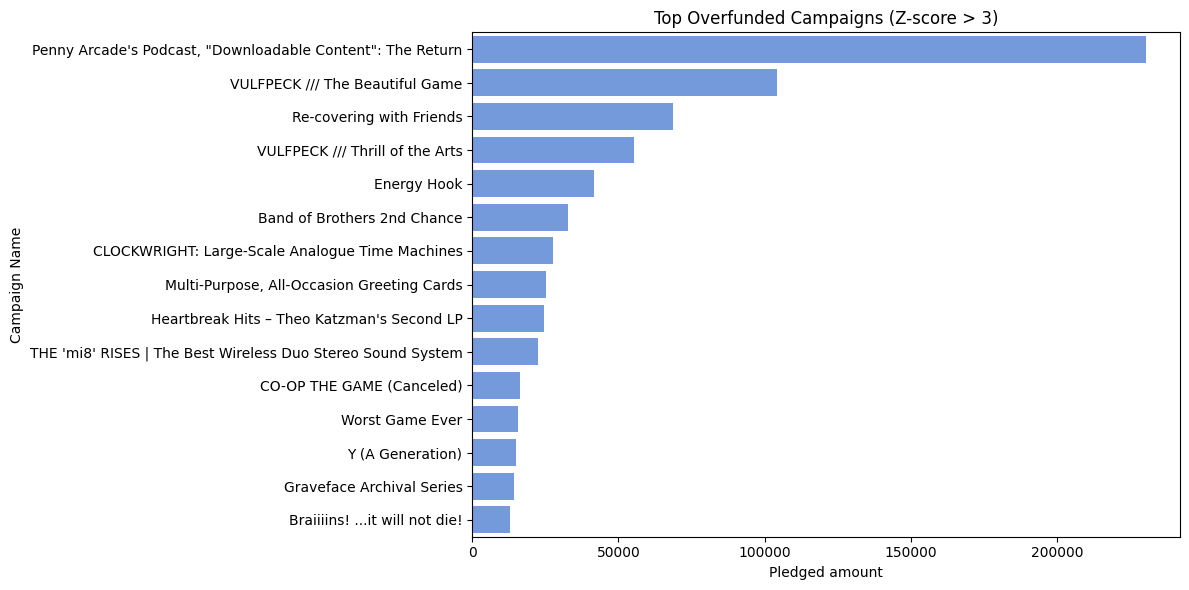

In [ ]:
# Create a horizontal bar plot of top overfunded campaigns (Z-score > 3)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=over_outliers.head(15).sort_values(by='Pledged',ascending=False),
    y='Name',
    x='Pledged',
    color='cornflowerblue'
)
plt.title('Top Overfunded Campaigns (Z-score > 3)')
plt.xlabel('Pledged amount')
plt.ylabel('Campaign Name')
plt.tight_layout()
plt.show()

# Model Building

# Data Prep

In [ ]:
# Step 2: Filter only 'Successful' and 'Failed' and encode them
df_filtered = df[df['State'].isin(['Successful', 'Failed'])].copy()
df_filtered['State'] = df_filtered['State'].map({'Failed': 0, 'Successful': 1})

# Display value counts to confirm conversion
state_counts = df_filtered['State'].value_counts()
df_filtered.head(), state_counts

(           ID                                               Name  \
 0  1860890148  Grace Jones Does Not Give A F$#% T-Shirt (limi...   
 1   709707365                     CRYSTAL ANTLERS UNTITLED MOVIE   
 2  1703704063                                drawing for dollars   
 3      727286                       Offline Wikipedia iPhone app   
 4  1622952265                                         Pantshirts   
 
        Category   Subcategory        Country            Launched   Deadline  \
 0       Fashion       Fashion  United States 2009-04-21 21:02:48 2009-05-31   
 1  Film & Video        Shorts  United States 2009-04-23 00:07:53 2009-07-20   
 2           Art  Illustration  United States 2009-04-24 21:52:03 2009-05-03   
 3    Technology      Software  United States 2009-04-25 17:36:21 2009-07-14   
 4       Fashion       Fashion  United States 2009-04-27 14:10:39 2009-05-26   
 
     Goal  Pledged  Backers  State  Duration  LaunchMonth  Pledged_to_Goal  \
 0   1000      625      

In [ ]:
# Step 3: Drop unhelpful or leaky columns
df_filtered.drop(columns=['ID', 'Name', 'Pledged'], inplace=True)

# Show updated DataFrame structure
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 331459 entries, 0 to 374605
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Category                  331459 non-null  object        
 1   Subcategory               331459 non-null  object        
 2   Country                   331459 non-null  object        
 3   Launched                  331459 non-null  datetime64[ns]
 4   Deadline                  331459 non-null  datetime64[ns]
 5   Goal                      331459 non-null  int64         
 6   Backers                   331459 non-null  int64         
 7   State                     331459 non-null  int64         
 8   Duration                  331459 non-null  int64         
 9   LaunchMonth               331459 non-null  int32         
 10  Pledged_to_Goal           331459 non-null  float64       
 11  Pledged_to_Goal_logratio  331459 non-null  float64       
 12  Z_score

In [ ]:
df_filtered.drop(columns=['Launched', 'Deadline', 'Z_score','Pledged_to_Goal_logratio','Pledged_to_Goal'], inplace=True)


In [ ]:
from sklearn.preprocessing import  LabelEncoder

# Step 5: Apply Ordinal Encoding to categorical columns
label_encoder = LabelEncoder()
df_filtered['Category'] = label_encoder.fit_transform(df_filtered['Category'])
df_filtered['Subcategory'] = label_encoder.fit_transform(df_filtered['Subcategory'])
df_filtered['Country'] = label_encoder.fit_transform(df_filtered['Country'])

# Show updated dataframe
df_filtered.head()


,Category,Subcategory,Country,Goal,Backers,State,Duration,LaunchMonth
0,5,52,21,1000,30,0,39,4
1,6,129,21,80000,3,0,87,4
2,0,70,21,20,3,1,8,4
3,13,131,21,99,25,1,79,4
4,5,52,21,1900,10,0,28,4


In [ ]:
from sklearn.model_selection import train_test_split

# Step 6: Split into features and target
X = df_filtered.drop("State", axis=1)
y = df_filtered["State"]

# 80/20 train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Show shape of the splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((265167, 7), (66292, 7), (265167,), (66292,))

In [ ]:
from sklearn.preprocessing import StandardScaler

# Step 7: Feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Show shape of scaled features
X_train_scaled.shape, X_test_scaled.shape


((265167, 7), (66292, 7))

# Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

# Step 8: Train the Logistic Regression model
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Predict on test data
y_pred = logreg.predict(X_test_scaled)

# Show first few predictions
y_pred[:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Step 9: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict = True)
class_report = pd.DataFrame(class_report).transpose()

print("Accuracy", accuracy)
print(class_report)

Accuracy 0.8677065105895131
              precision    recall  f1-score       support
0              0.841856  0.958074  0.896213  39522.000000
1              0.922258  0.734292  0.817611  26770.000000
accuracy       0.867707  0.867707  0.867707      0.867707
macro avg      0.882057  0.846183  0.856912  66292.000000
weighted avg   0.874324  0.867707  0.864472  66292.000000


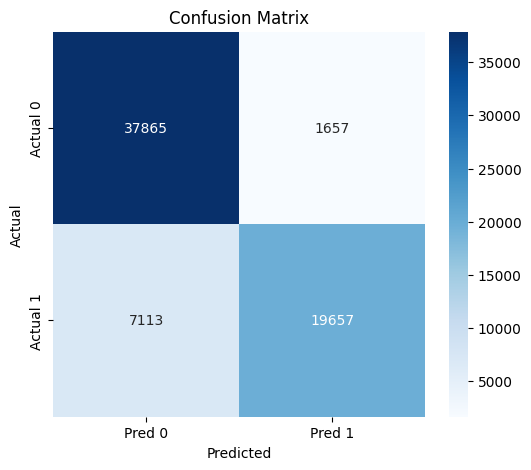

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
feature_importance = pd.Series(logreg.coef_[0], index=X.columns).sort_values(ascending=False)
feature_importance

,0
Backers,36.798734
Country,0.115651
Subcategory,0.007977
Category,-0.016358
LaunchMonth,-0.034347
Duration,-0.176889
Goal,-109.671572


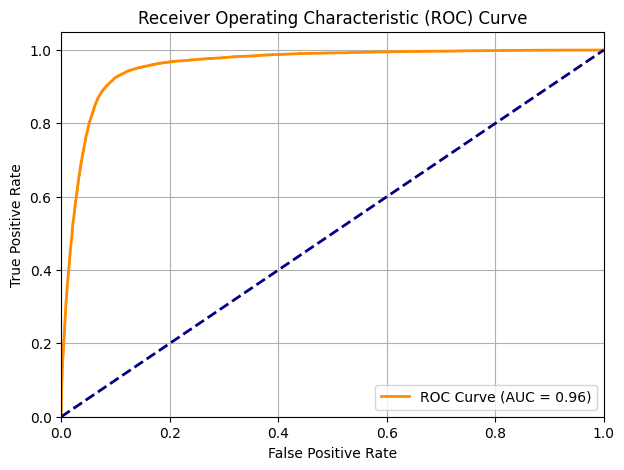

In [ ]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for ROC curve
y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Decision Tree

In [ ]:
# Step 8: Train Decision Tree model
dtree = DecisionTreeClassifier(random_state=42, max_depth=4)
dtree.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred_dt = dtree.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
class_report_dt = classification_report(y_test, y_pred_dt, output_dict=True)
class_report_dt = pd.DataFrame(class_report_dt).transpose()

accuracy_dt, class_report_dt

(0.9108791407711337,
               precision    recall  f1-score       support
 0              0.937979  0.910733  0.924155  39522.000000
 1              0.873630  0.911095  0.891969  26770.000000
 accuracy       0.910879  0.910879  0.910879      0.910879
 macro avg      0.905804  0.910914  0.908062  66292.000000
 weighted avg   0.911993  0.910879  0.911158  66292.000000)

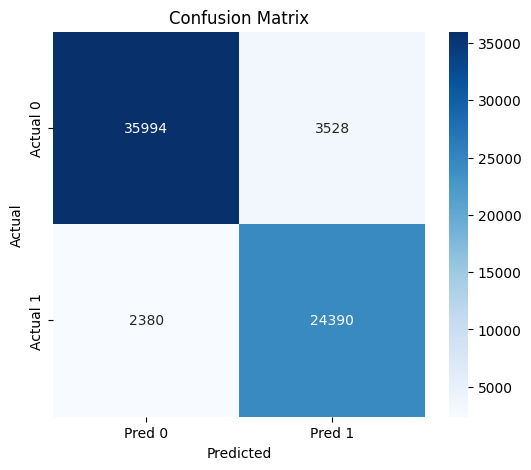

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

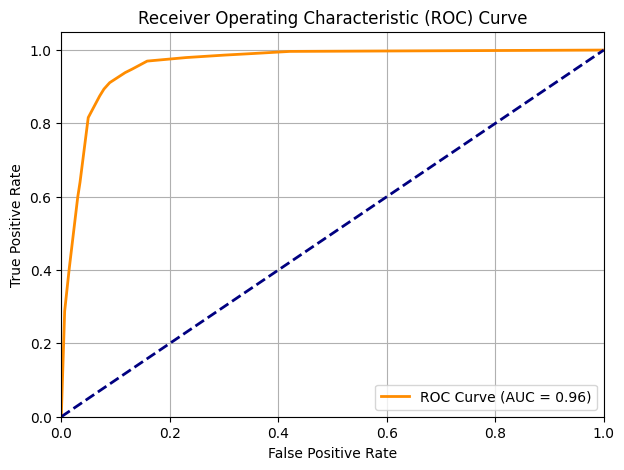

In [ ]:
# Predict probabilities for ROC curve
y_prob_dt = dtree.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
# Re-do the tree without standardizing for the decision tree graph
dtree = DecisionTreeClassifier(random_state=42, max_depth=4)
dtree.fit(X_train, y_train)

# Predictions and evaluation
y_pred_dt = dtree.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
class_report_dt = classification_report(y_test, y_pred_dt, output_dict=True)
class_report_dt = pd.DataFrame(class_report_dt).transpose()

accuracy_dt, class_report_dt

(0.9108791407711337,
               precision    recall  f1-score       support
 0              0.937979  0.910733  0.924155  39522.000000
 1              0.873630  0.911095  0.891969  26770.000000
 accuracy       0.910879  0.910879  0.910879      0.910879
 macro avg      0.905804  0.910914  0.908062  66292.000000
 weighted avg   0.911993  0.910879  0.911158  66292.000000)

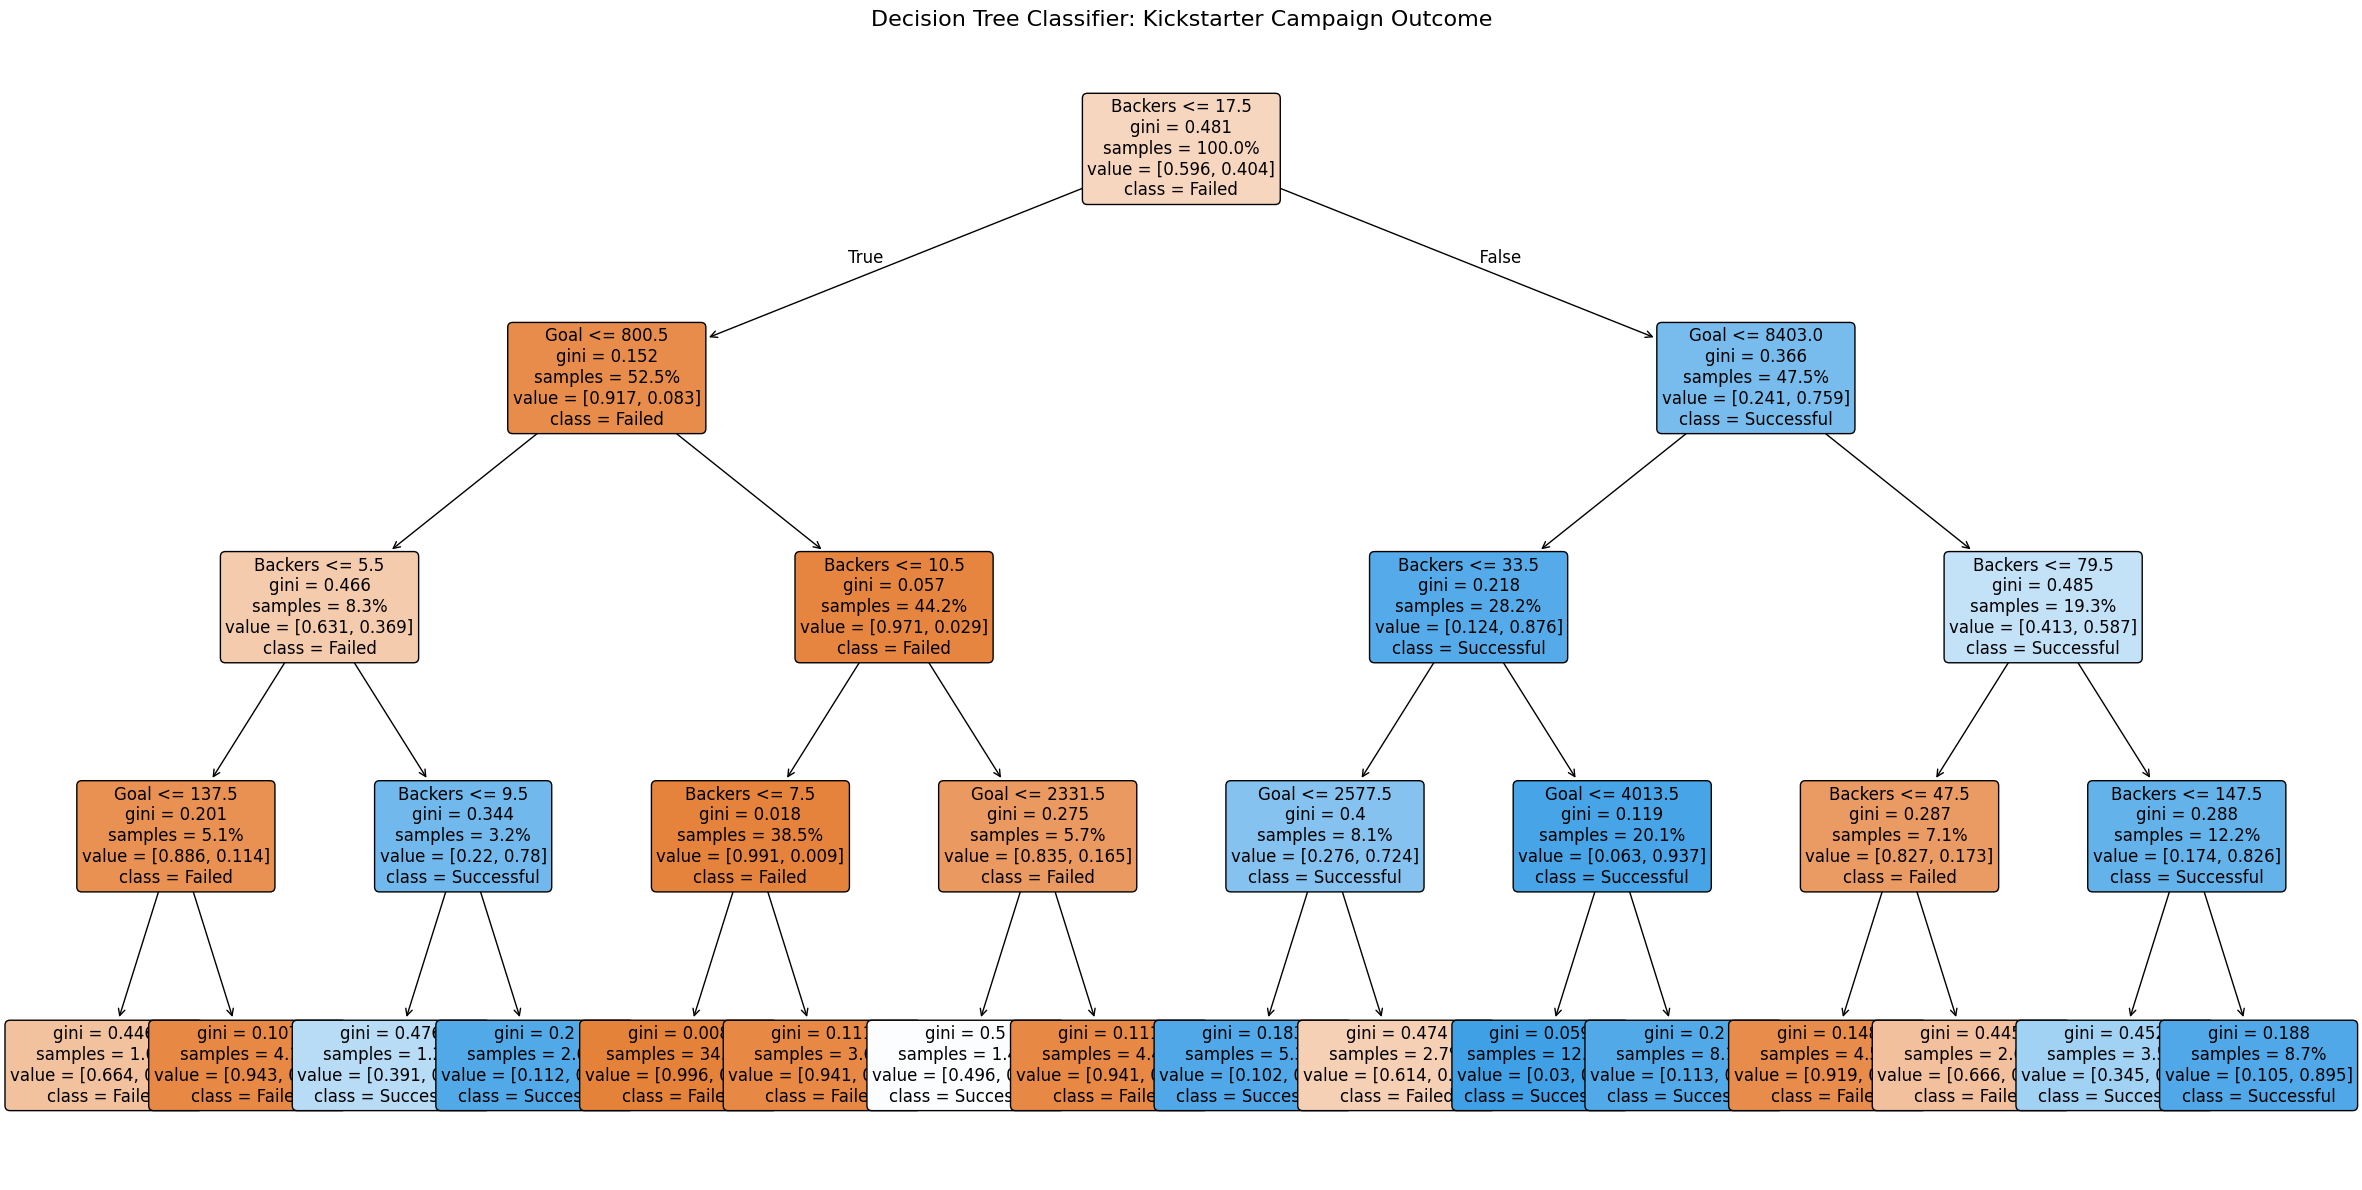

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Set larger figure size and font scale
plt.figure(figsize=(24, 12))  # Wider and taller
plot_tree(
    dtree,
    feature_names=X.columns,                # Feature labels
    class_names=['Failed', 'Successful'],   # Target labels
    filled=True,                            # Color code by class purity
    rounded=True,                           # Rounded boxes
    fontsize=12,                            # Larger text for readability
    proportion=True                         # Proportional leaf sizes
)
plt.title("Decision Tree Classifier: Kickstarter Campaign Outcome", fontsize=16)
plt.tight_layout()
plt.show()
